Osnabrück University - Computer Vision (Winter Term 2020/21) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland, Ludwig Schallner, Artem Petrov

# Exercise Sheet 09: Filter, Sampling, and Template Matching

## Introduction

This week's sheet should be solved and handed in before the end of **Saturday, January 16, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Exercise 0: Math recap (Covariance) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What does *covariance* express?

YOUR ANSWER HERE

**b)** Provide a formula to compute the covariance of two 1-dimensional datasets. How can it be generalized to the $n$-dimensional case?

YOUR ANSWER HERE

**c)** Create and plot two (1-dimensional) datasets with low covariance (use `plt.scatter`). Then do the same for two datasets with high covariance.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# YOUR CODE HERE

## Exercise 1: Filter design [6 points]

**a)** Create and plot the kernels of box filter and binomial filter in frequency space. Vary the the kernel size. What do you observe?

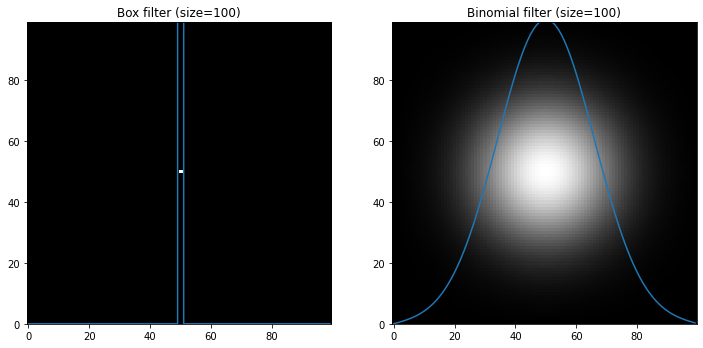

In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

kernel_size = 100 # vary this
image_size = 100

def gkern(l, sig):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)
    raw_kernel=-0.5 *(np.square(xx) + np.square(yy))
    kernel = np.exp(raw_kernel / np.square(sig))
    return kernel / np.sum(kernel)

box_kernel = np.ones((kernel_size,kernel_size))
binomial_kernel = np.zeros((image_size,image_size))

binomial_kernel=gkern(kernel_size, 1)

box_frequencies = np.fft.fftshift(np.fft.fft2(box_kernel))
binomial_frequencies = np.fft.fftshift(np.fft.fft2(binomial_kernel))

# plot kernel in frequency space
plt.figure(figsize=(12,6))
plt.gray()
plt.subplot(1,2,1)
plt.title(f"Box filter (size={kernel_size})")
plt.imshow(np.abs(box_frequencies))
plt.plot(np.arange(image_size), np.abs(box_frequencies)[image_size//2]*image_size)
plt.ylim(0, image_size-1)
plt.subplot(1,2,2)
plt.title(f"Binomial filter (size={kernel_size})")
plt.imshow(np.abs(binomial_frequencies))
plt.plot(np.arange(image_size), np.abs(binomial_frequencies)[image_size//2]*image_size)
plt.ylim(0, image_size-1)
plt.show()

The box kernel give aus a white square in frequenc space, that gets smaller with the kernel size. The binomial filter again give a 2D-binomial signal in frequency space.

**b)** Implement a low pass filter and apply it to the given image with different cut of frequencies $F_\max$. What do you observe? Explain that observation and discuss how to improve the result.

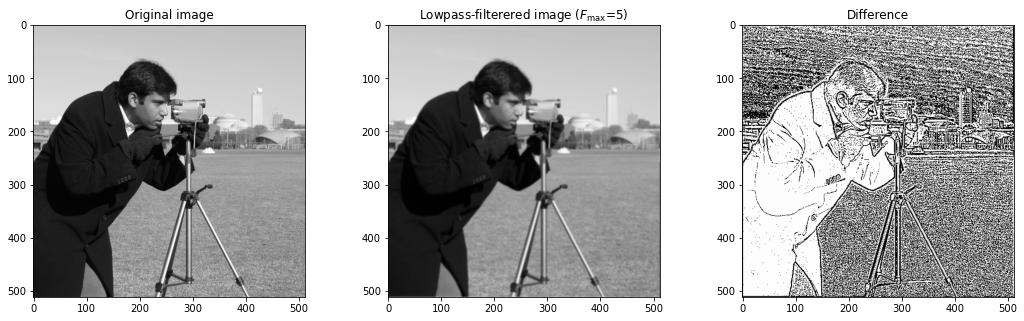

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

f_max = 5
image = imageio.imread('imageio:camera.png')

def low_pass_filter(img, f_max):
    
    #radius of filter circle -> 1 equals 1 bit strength for filtering
    r = f_max
    
    img_length=img.shape[0]
    
    #1D hamming -> Fuction for hamming window -> Could use any other function like gausian kernel to build a 2D filter
    ham = np.hamming(img_length)[:,None] 
    #Create 2D-Kernel by matrix multiplication -> Values rangeing from 0 to 1 in ham. A great r will result in small values around the maximum of 1.
    ham2d = np.sqrt(np.dot(ham, ham.T)) ** r 
    
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)
    fft_filtered = ham2d * fft_shifted
    
    #shift back?
    fft_filtered_shifted = np.fft.fftshift(fft_filtered)
    inv_img = np.fft.ifft2(fft_filtered_shifted)
    filtered_img = np.abs(inv_img)
    
    #To enhance differences especially for small filter sizes
    #Scale to 255 bit -> Better to calculate deviations
    filtered_img = filtered_img-filtered_img.min()
    filtered_img = filtered_img / filtered_img.max()
    filtered_img = filtered_img*255
    filtered_img = filtered_img.astype(np.uint8)

    result=filtered_img
    
    return result

filtered_image = low_pass_filter(image, f_max=f_max)

# plot kernel in frequency space
plt.figure(figsize=(18,5))
plt.gray()
plt.subplot(1,3,1); plt.title(f"Original image")
plt.imshow(image) 
plt.subplot(1,3,2); plt.title(f"Lowpass-filterered image ($F_\max$={f_max})")
plt.imshow(filtered_image)
plt.subplot(1,3,3); plt.title(f"Difference")
plt.imshow(filtered_image-image)
plt.show()

With rising numbers of f_max the filter will increase the amount of filtered frequencies. With this hamming style filter no artifacts are going to occur -> a good solution from my point of view.

**c)** What is a good kernel size for a Gaussian filter? Justify your answer.

A rather big kernel for a Gaussian filter would be a good choice, because this leads to an averaging over a larger area and therefore to a stronger low-pass filtering. Thus, the linear smoothing increases as the soft cut off low-pass filter filters out the noisy high frequencies.

**d)** Describe impulse ("salt and pepper") noise and explain what kind of filter should be used to remove such noise.

Impulse noise is characterized by pixels of an image that take the minimum or maximum gray value (black or white) randomly. Thus, these noisy pixels can be removed best by local averaging since they occur randomly and do not affect their neighboring pixels. A box-filter will be a good choice as it applies local averaging to an image.

## Exercise 2: Sampling theorem [4 points]

**a)** Express the statement of the sampling theorem in your own words. Explain its relevance.

r >= 2 * W 

The sampling theorem states that the sampling rate r (sampling frequency) needs to be higher than 2*W, where W is the highest frequency of a measured signal (so r needs to be at least twice as high as W). This is necessary to capture enough information to be able to reconstruct the signal after discretization correctly (and to not "miss" higher underlying frequencies).  

That means that the distance between the delta peaks delta x needs to be:

delta x <= 1/(2 * W)    or     1/delta x >= 2 * W

**b)** Assume you are given a document printed on a 600 dpi (dots per inch) printer. If you want to scan this document, what resolution should you choose to avoid aliasing effects?

600 dots/inch -> frequency W = 600,   required: r (resolution is another word for sampling rate r in this case)

r >= 2 * W = 2 * 600 = 1200

The resolution r needs to be >= 1200 units/inch.

**c)** What is aliasing? Explain the Moiré effect shown in the following cell.

<IPython.core.display.Javascript object>


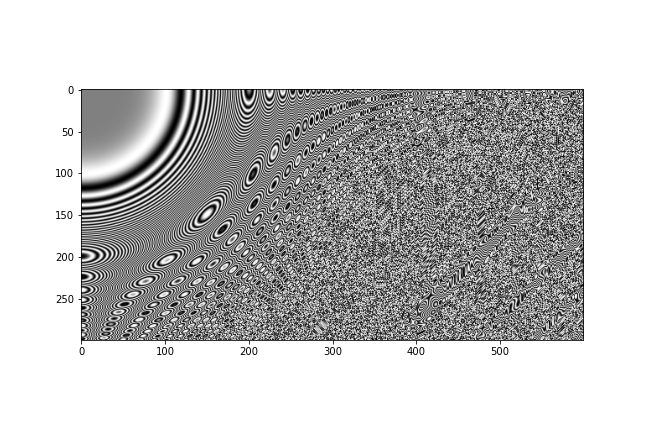

interactive(children=(FloatSlider(value=4.0, description='exp', max=8.0, min=1.0, step=0.5), Output()), _dom_c…

In [8]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, fixed
from IPython.display import display

def plotter(function, **kwargs):
    img = function(**kwargs)
    imshow.set_data(img)
    fig.canvas.draw()

def moire(exp):
    return np.sin(d**exp)

nx, ny = (600, 300)
x = np.linspace(0, nx*np.pi/ny, nx)
y = np.linspace(0, np.pi, ny)
xv, yv = np.meshgrid(x, y)
d = np.sqrt(xv**2+yv**2)

fig, ax = plt.subplots(figsize=(9,6))
imshow = plt.imshow(np.sin(d))
plt.gray()
interactive(plotter, function=fixed(moire), exp=(1,8,0.5))

Aliasing describes the effect that occurs when a signal is sampled with a too low sampling rate r. This leads to an incorrect discretization and therefore to a wrong, lower frequency of the discretized signal. Thus, the original higher frequency of the signal "gets lost".

The Moiré effect is an optical effect in which the superposition of regular grids creates a periodic grid that has special structures that are not present in any of the individual grids and that vary when the method of superposition is changed. Thus, its a perfect example of Aliasing. 

**d)** Gaussian pyramid: motivate the construction process of a Gaussian pyramid with the sampling theorem.

The Gaussian pyramid is quartered between every downsizing level. So it is halved along both image axes which agrees with the sampling theorem. EXACT REASON WHY TO DO THIS??? 

## Exercise 3: Template Matching [4 points]

**a)** Explain in your own words the idea of *template matching*. Is it a data or model based approach? What are the advantages and disadvantages? In what situations would you apply template matching?

Template matching searches for a given template (e.g. a simple model of the searched object -> in form of a simplified image or a convolutional kernel) in an image. 

Advantage: It is a simple and therefore computational fast approach to to find rather simple and distinct objects in an image. Additionally, it is robust again noise.

Disadvantage: It is only able to find simple objects. Also, it only has a little robustness against variation of viewpoint and illumination. 

It is often used in industry tasks where a little computation time is needed.

**b)** Explain the ideas of *mean absolute difference* and *correlation coefficient*? Name pros and cons.

The mean absolute difference (MAD) is a measure for the similarity/ distance between template and image (mean difference of the gray values).

Pros: Due to intergration, it is robust against noise.

Cons: Little robustness against variation of viewpoint and illumination. 

The correlation coefficient is also a measure for the similarity/ distance, but includes the covariance between the image and the template and the standard deviations of image and template.

Pros: Illumaination (Scaling of the gray values) is no problem.

Cons: For more complex patterns, the template is too large for direct computation and therefore Fourier transform has to be used.

## Exercise 4: Where is Waldo [6 points]

In the two images `wheresWaldo1.jpg` and `wheresWaldo2.jpg`, Waldo is hiding in the midst of a busy crowd. He always wears the same red and white striped sweater and hat. However, he may be carrying a something that varies from scene to scene. Use template matching with the given Waldo templates (`waldo*.jpg`) to locate Waldo. Highlight
Waldo in the scene and indicate which template was matched.

**Hints:**
* You may use buildin functions to solve this exercise.
* The images are quite large! You may start by testing your code on a small image patch before applying it to the full scene.
* You may not achieve a perfect match. Analyse the problems you encounter and think how you can improve your result.

If you intend to use the [OpenCV library](https://opencv.org/) in this task, use the following command to install an appropriate version (we will also need this at some later exercise sheet):
```sh
conda install --channel conda-forge opencv
```

In [114]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2 

waldos = [plt.imread('images/waldo/wheresWaldo{}.jpg'.format(i)) for i in range(1, 3)]
templates = [plt.imread('images/waldo/waldo{}.jpg'.format(i)) for i in range(0, 6)]

plt.figure(figsize = (14, 40))
for i,img in enumerate(waldos):
    plt.subplot(len(waldos),1,i+1)
    plt.imshow(img)
    
plt.figure(figsize = (14, 10))
for i,img in enumerate(templates):
    plt.subplot(1,len(templates),i+1)
    plt.imshow(img)
    
    
# YOUR CODE HERE

FileNotFoundError: [Errno 2] No such file or directory: 'images/waldo/wheresWaldo1.jpg'

In [ ]:
# YOUR CODE HERE